In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
import glob
import os.path
import cv2
import seaborn as sns
import pandas as pd

In [3]:
IMG_SIZE = 224

In [4]:
classes = ['credit_card', 'passport', 'receipt']

ds_cfg = dict(
    labels='inferred',
    label_mode="int",
    class_names=classes,
    color_mode='rgb',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=64,
    shuffle=True,
    seed=123,
    validation_split=0.3,
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/documents/raw',
    subset="training",
    **ds_cfg
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './datasets/documents/raw',
    subset="validation",
    **ds_cfg
)

def augment(x, y):
    image = tf.image.random_brightness(x, max_delta=0.05)
    return image, y

train_ds = train_ds.map(augment)

Found 1067 files belonging to 3 classes.
Using 747 files for training.
Found 1067 files belonging to 3 classes.
Using 320 files for validation.


In [5]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)

data_augmentation = keras.Sequential([
    layers.RandomBrightness(factor=0.1),
    layers.RandomFlip("horizontal",input_shape=img_shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = Sequential([
  layers.Rescaling(1./255, input_shape=img_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.28),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(classes))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/Users/piotrpersona/anaconda3/envs/doclass/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.3767 - loss: 1.7513 - val_accuracy: 0.5031 - val_loss: 0.8967
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.5034 - loss: 0.8809 - val_accuracy: 0.6469 - val_loss: 0.6895
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.7237 - loss: 0.6179 - val_accuracy: 0.8656 - val_loss: 0.4542
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.8443 - loss: 0.4177 - val_accuracy: 0.8406 - val_loss: 0.3895
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8866 - loss: 0.3474 - val_accuracy: 0.8594 - val_loss: 0.3584
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.9003 - loss: 0.2614 - val_accuracy: 0.8219 - val_loss: 0.4835
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - accuracy: 0.9158 - loss: 0.2385 - val_accuracy: 0.8781 - val_loss: 0.3028
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.9354 - loss: 0.1705 - val_accuracy: 0.

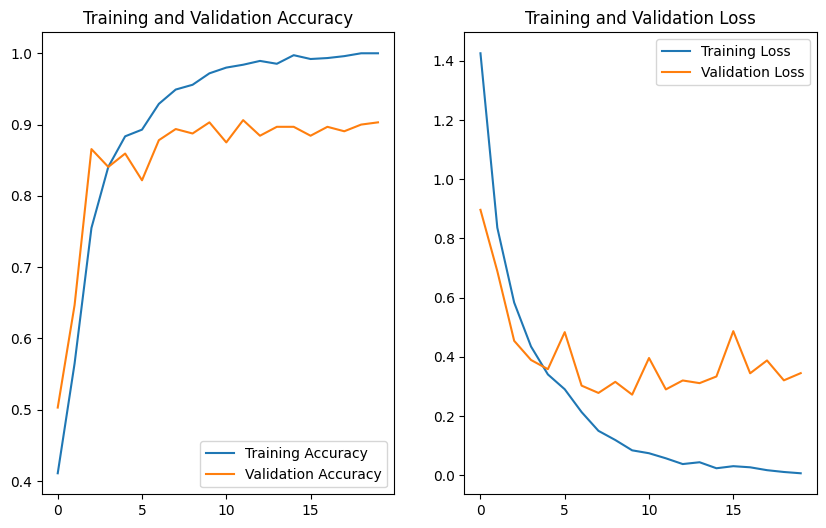

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
predictions_result = []
for image_file in glob.glob("./datasets/documents/val/*/*"):    
    img = tf.keras.utils.load_img(image_file)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predictions_result.append(dict(
        label=image_file.split("/")[-2],
        predicted_label=classes[np.argmax(score)],
        score=100 * np.max(score),
    ))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

Text(0.5, 23.38159722222222, 'predicted_label')

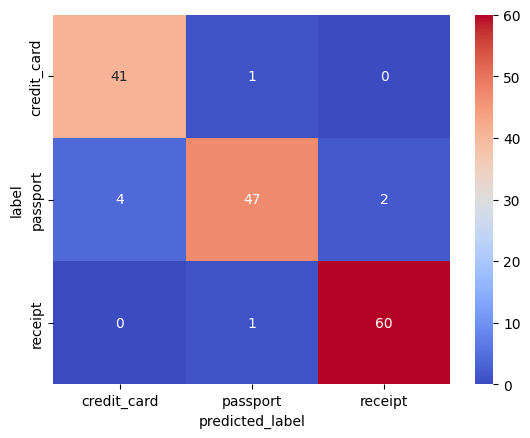

In [9]:
confusion_matrix = np.zeros(shape=(len(classes), len(classes)))
for pred in predictions_result:
    pred_label = np.where(np.array(classes) == pred['predicted_label'])[0][0]
    label = np.where(np.array(classes) == pred['label'])[0][0]
    confusion_matrix[label][pred_label] += 1
cm_df = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
ax = sns.heatmap(cm_df, annot=True, cmap="coolwarm")
ax.set_ylabel('label')
ax.set_xlabel('predicted_label')

In [16]:
model.save(f'./models/cnn-e{epochs}-val{val_acc[-1]:.2f}.keras')